In [67]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Glen's beam from Yunhai's 3D paper

In [2]:
# Glen's beam, which comes from Yunhai's 3D CSR paper!

gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2



# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread


# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

### Yunhai's beam for transient wakes

In [2]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

## code

In [68]:
# Copy of a section from kick2.py

from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

def csr2d_kick_calc_case_B(
    z_b,x_b,weight,*,
    gamma=None,rho=None,nz=100,nx=100,xlim=None,zlim=None,
    reuse_psi_grids=False,psi_s_grid_old=None,psi_x_grid_old=None,map_f=map,
    species="electron",imethod='map_coordinates',debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma ** 2)

    t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
    
    if debug:
        t5 = time.time()
        print("Convolution takes:", t5 - t4, "s")

    Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
    
    return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx

In [80]:
zvec,xvec,zvec2,xvec2, lambda_grid_filtered, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, Ws_grid, Wx_grid, dz, dx = csr2d_kick_calc_case_B(beam[4,:], beam[0,:], 
                                           charges, gamma=gamma, rho=rho, 
                                           nz=300, nx=200,
                                           map_f = map, debug=True)

Depositing particles takes: 0.02391672134399414 s
Computing potential grids take: 0.026411056518554688 s
Convolution takes: 0.03156256675720215 s


Text(0.5, 0.92, '$\\psi_x$ benchmarking')

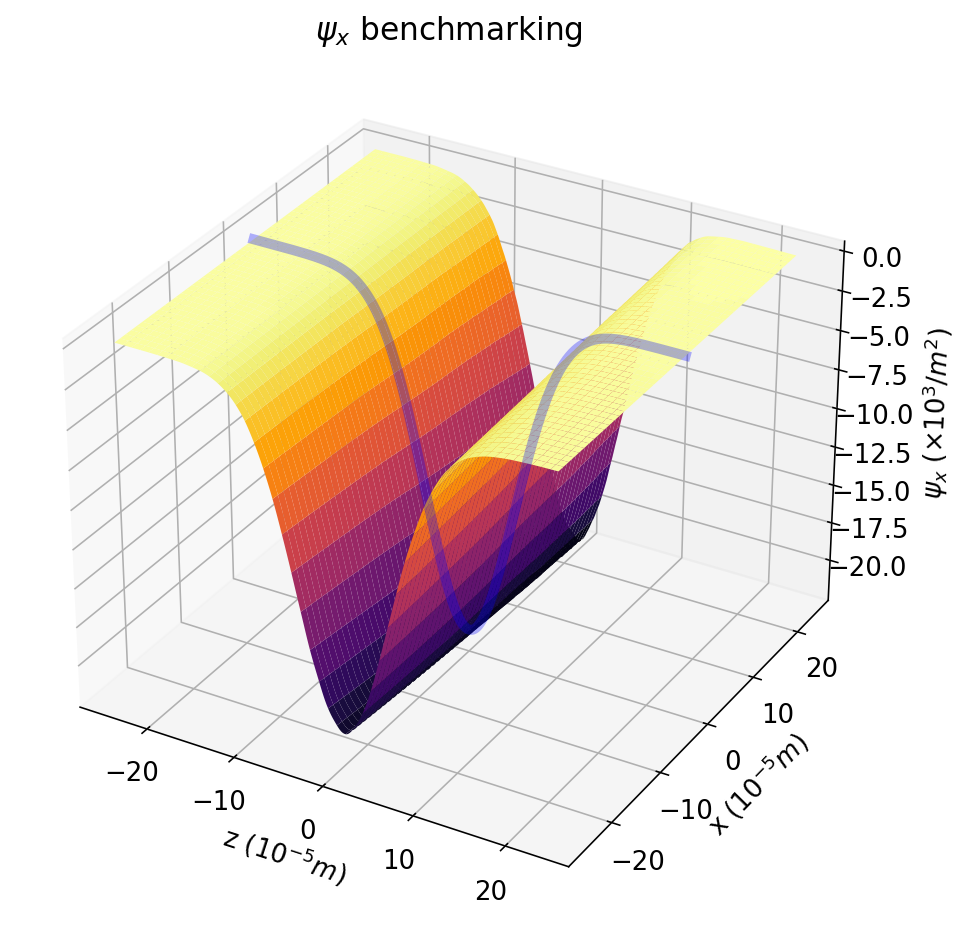

In [81]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Wx_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
zline = np.linspace(min(zvec), max(zvec), 1000)
xline = np.zeros(len(zline))
fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$\psi_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$\psi_x$ benchmarking')

#ax.azim = 90

#### psi_s(zi) depends on (x-x') only
#### Fix observation x to be x_o as before, then psi_s(zi) is psi_s_zi_vec(x')

In [125]:
# phi is the angle into the bend 
# x_observe should be a value in x_vec ( zero might not be one )..... TO BE FIXED

# The code here will replace the convolution section in the "csr2d_kick_calc_case_B" above

from csr2d.core2 import psi_s, psi_x0
from scipy.interpolate import RectBivariateSpline

def compute_transient_wake_case_B(phi, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid):

    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec2)

    
    # Computing the integral term of case B
    # Want "True" if (z > zi) OR (z < zo), where the potential values are set to ZERO
    condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])
    psi_s_grid_bounded = np.where(condition_grid.T, 0, psi_s_grid)
    psi_x_grid_bounded = np.where(condition_grid.T, 0, psi_x_grid)
    conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid_bounded, psi_x_grid_bounded)
    Ws_grid = (beta**2 / abs(rho)) * (conv_s) * (dz * dx)
    Wx_grid = (beta**2 / abs(rho)) * (conv_x) * (dz * dx)
    
    # Computing the two boundary terms of case B 
    # ==========================================
    lambda_interp = RectBivariateSpline(zvec, xvec, lambda_grid_filtered)  # lambda lives in the observation grid
    
    lambda_zi_vec = lambda z: lambda_interp.ev( z - zi_vec, xvec2 )
    psi_s_zi_vec = psi_s(zi_vec/2/np.abs(rho), temp, beta)
    Ws_zi = lambda z: (beta**2 / abs(rho)) * np.dot(psi_s_zi_vec, lambda_zi_vec(z))*dx
    Ws_zi_vec = np.array(list(map(Ws_zi, zvec)))
    psi_x_zi_vec = psi_x0(zi_vec/2/np.abs(rho), temp, beta, dx)
    Wx_zi = lambda z: (beta**2 / abs(rho)) * np.dot(psi_x_zi_vec, lambda_zi_vec(z))*dx
    Wx_zi_vec = np.array(list(map(Wx_zi, zvec)))
    
    
    lambda_zo_vec = lambda z: lambda_interp.ev( z - zo_vec, xvec2 )
    psi_s_zo_vec = psi_s(zo_vec/2/np.abs(rho), temp, beta)
    Ws_zo = lambda z: (-1.0) * (beta**2 / abs(rho)) * np.dot(psi_s_zo_vec, lambda_zo_vec(z))*dx
    Ws_zo_vec = np.array(list(map(Ws_zo, zvec)))
    psi_x_zo_vec = psi_x0(zo_vec/2/np.abs(rho), temp, beta, dx)
    Wx_zo = lambda z: (-1.0) * (beta**2 / abs(rho)) * np.dot(psi_x_zo_vec, lambda_zo_vec(z))*dx
    Wx_zo_vec = np.array(list(map(Wx_zo, zvec)))
    
    # ==========================================
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index )

    #return zi_vec, psi_s_zi_vec, W_zi_vec 
    return Ws_grid[:,x_observe_index], Ws_zi_vec, Ws_zo_vec, Wx_grid[:,x_observe_index], Wx_zi_vec, Wx_zo_vec

    #return psi_x_zi_vec
    #return Ws_grid[:,x_observe_index]
    #return Ws_grid

# Results

x_observe_index : 51
x_observe_index : 102
x_observe_index : 154


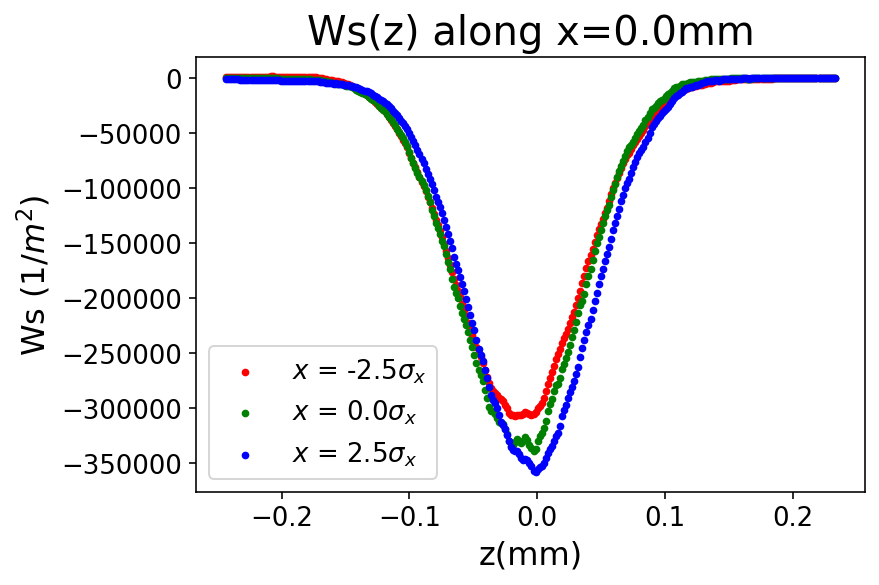

In [141]:
# Check with Yunhai's example

xo_vec = [-2.5*sigma_x, 0.0, 2.5*sigma_x]

ffB = lambda xo : compute_transient_wake_case_B(0.1/rho, xo, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
wake_listB = np.array(list(map(ffB, xo_vec)))

ws1 = wake_listB[0][0] + wake_listB[0][1] + wake_listB[0][2]
ws2 = wake_listB[1][0] + wake_listB[1][1] + wake_listB[1][2]
ws3 = wake_listB[2][0] + wake_listB[2][1] + wake_listB[2][2]

plt.scatter(zvec*10**3, ws1, color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, ws2, color='green', label='$x$ = '+str(xo_vec[1]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, ws3, color='blue', label='$x$ = '+str(xo_vec[2]/sigma_x) + '$\sigma_x$', s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Ws $(1/m^2)$', fontsize=16)
#plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B, zi-boundary term',  fontsize=20)
plt.title('Ws(z) along x=' + str(x_observe*1000) +'mm',  fontsize=20)
plt.legend()

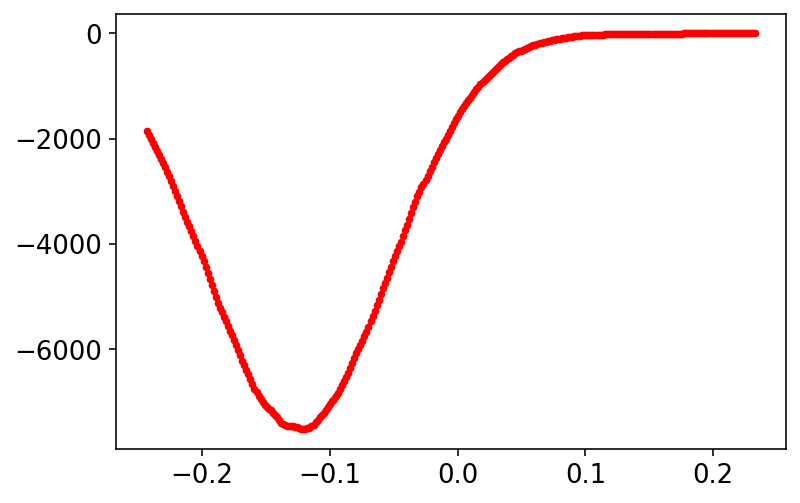

In [138]:
#ws1 = wake_listB[0][3] + wake_listB[0][4] + wake_listB[0][5]
ws1 = wake_listB[0][5] 

plt.scatter(zvec*10**3, ws1, color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )


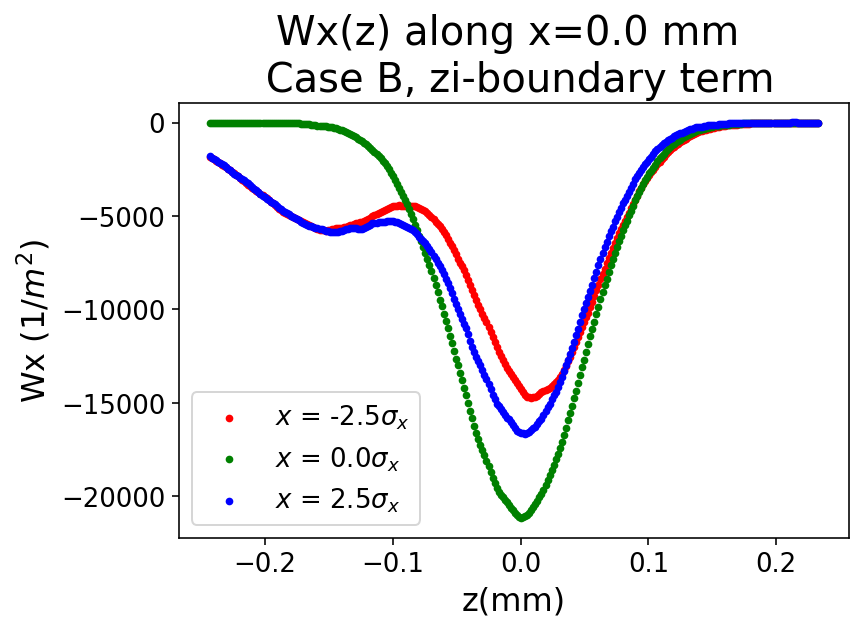

In [127]:
wx1 = wake_listB[0][3] + wake_listB[0][4] + wake_listB[0][5]
wx2 = wake_listB[1][3] + wake_listB[1][4] + wake_listB[1][5]
wx3 = wake_listB[2][3] + wake_listB[2][4] + wake_listB[2][5]

plt.scatter(zvec*10**3, wx1, color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, wx2, color='green', label='$x$ = '+str(xo_vec[1]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3, wx3, color='blue', label='$x$ = '+str(xo_vec[2]/sigma_x) + '$\sigma_x$', s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Wx $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B, zi-boundary term',  fontsize=20)
plt.legend()

In [144]:
# Check at many phi locations

x_observe = 0.0

#ffA = lambda a : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
#    gamma=gamma, rho=rho, phi = a, x_observe = 0,
#    nz=200, nx=150, debug=True)

ffB = lambda a : compute_transient_wake_case_B(a, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
phi_vec = [0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
#phi_vec = [0.04, 0.06, 0.08, 0.12, 0.16, 0.2, 0.24]

wake_list = list(map(ffB, phi_vec))

x_observe_index : 102
x_observe_index : 102
x_observe_index : 102
x_observe_index : 102
x_observe_index : 102
x_observe_index : 102


In [163]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def lamb_1d_prime(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2) * (-z / sigma_z**2)
def plot_Ws_caseB_zi_term_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/phi/rho * lamb_1d( zvec - rho*phi**3/24), color = color, linewidth=4, label = label)
    
def plot_Wx_caseB_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/rho * lamb_1d( zvec ), color = color, linewidth=4, label = label)

In [158]:
from scipy import integrate

# Case B integral term ( for large phi this goes to the s-s wake )
def get_Wss(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]

phi = phi_vec[0]
Wss_list1 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[1]
Wss_list2 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[2]
Wss_list3 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[3]
Wss_list4 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[4]
Wss_list5 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[5]
Wss_list6 = np.array(list(map(get_Wss, zvec)))

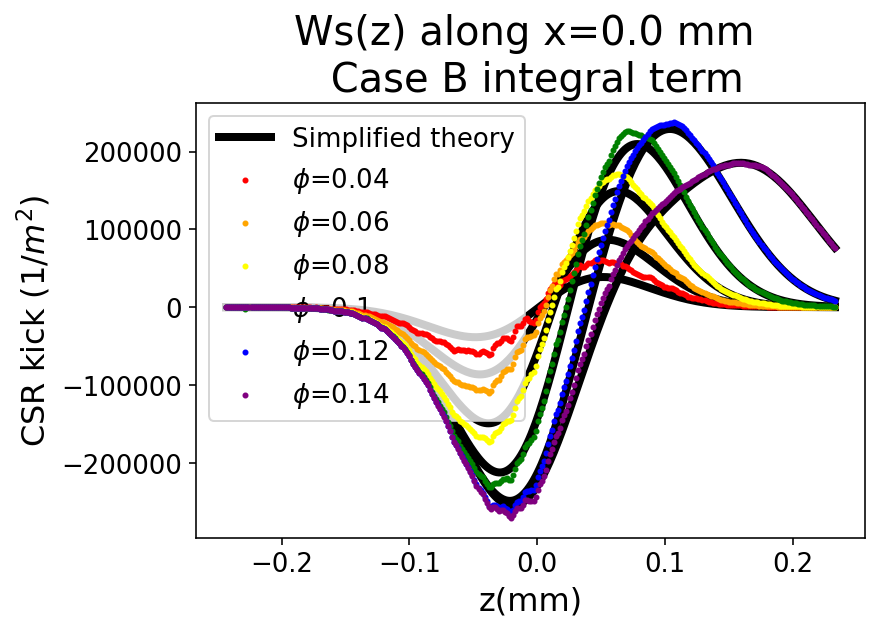

In [162]:
plt.scatter(zvec*10**3,wake_list[0][0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list[1][0], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[2][0], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[3][0], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][0], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[5][0], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, Wss_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, Wss_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list5, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list6, color = 'black', linewidth=4)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B integral term',  fontsize=20)
plt.legend(loc='upper left')

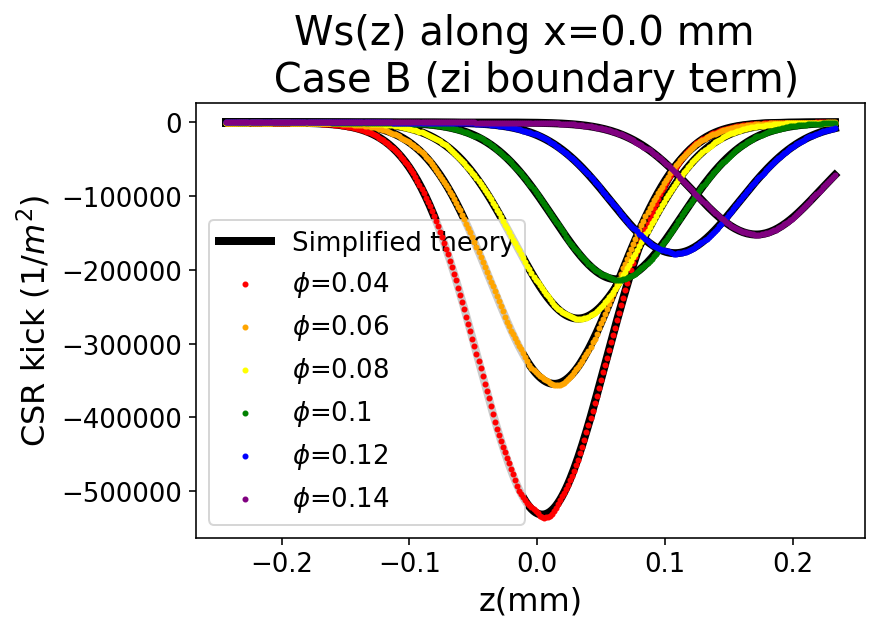

In [160]:
plt.scatter(zvec*10**3,wake_list[0][1], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_list[1][1], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[2][1], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[3][1], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][1], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[5][1], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


plot_Ws_caseB_zi_term_theory(phi_vec[0], 'black', 'Simplified theory')
plot_Ws_caseB_zi_term_theory(phi_vec[1], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[2], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[3], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[4], 'black')
plot_Ws_caseB_zi_term_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B (zi boundary term)',  fontsize=20)
plt.legend()

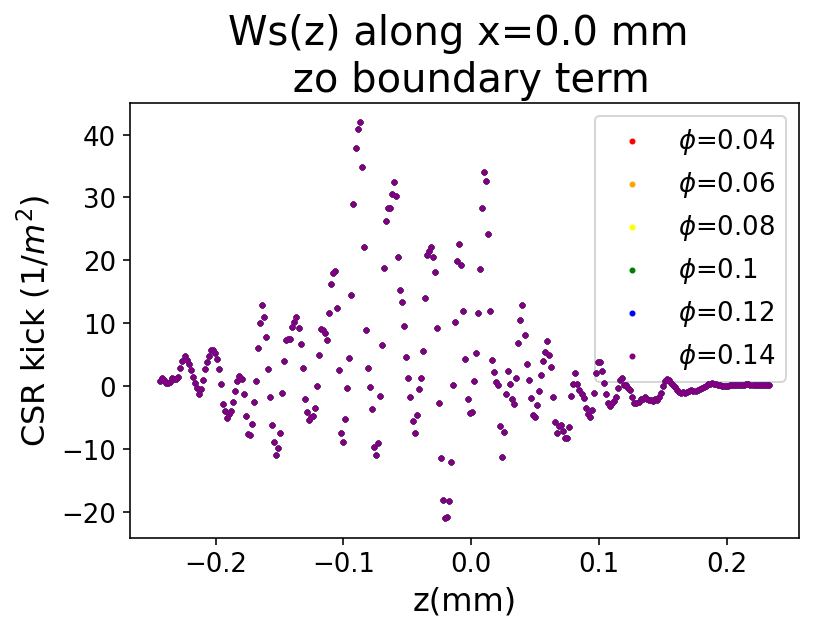

In [180]:
# The zo boundary term should be small comparing to the other 2 terms

plt.scatter(zvec*10**3,wake_list[0][2], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_list[1][2], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[2][2], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[3][2], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][2], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[5][2], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n zo boundary term',  fontsize=20)
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Wx(z) along x=0.0 mm \n Case B (integral term)')

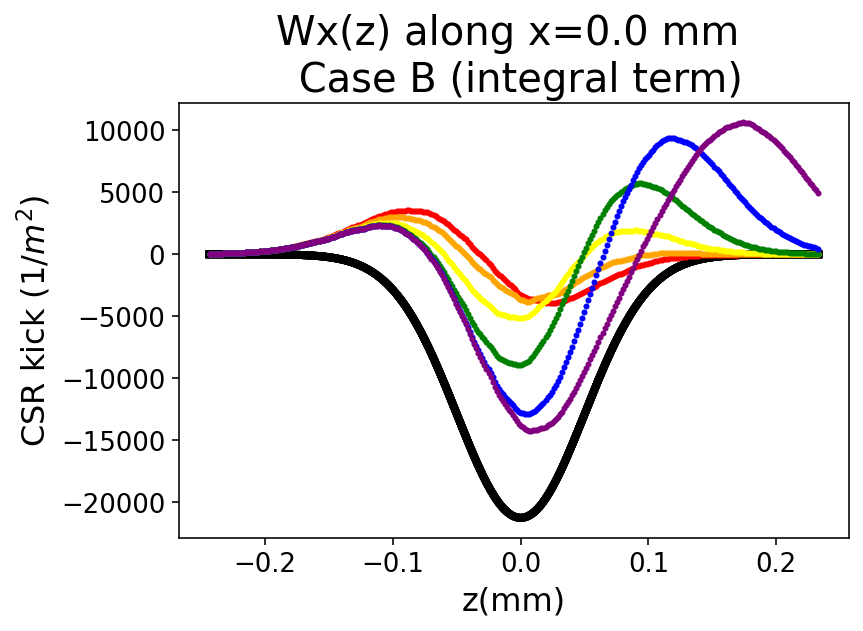

In [175]:
# Wx(z) on axis

wx1 = wake_list[0][3] + wake_list[0][4] + wake_list[0][5] 
wx2 = wake_list[1][3] + wake_list[1][4] + wake_list[1][5]
wx3 = wake_list[2][3] + wake_list[2][4] + wake_list[2][5]
wx4 = wake_list[3][3] + wake_list[3][4] + wake_list[3][5]
wx5 = wake_list[4][3] + wake_list[4][4] + wake_list[4][5]
wx6 = wake_list[5][3] + wake_list[5][4] + wake_list[5][5]


plt.scatter(zvec*10**3, wx1, color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3, wx2, color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3, wx3, color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3, wx4, color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3, wx5, color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3, wx6, color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


plot_Wx_caseB_theory(phi_vec[0], 'black', 'Simplified theory')
plot_Wx_caseB_theory(phi_vec[1], 'black')
plot_Wx_caseB_theory(phi_vec[2], 'black')
plot_Wx_caseB_theory(phi_vec[3], 'black')
plot_Wx_caseB_theory(phi_vec[4], 'black')
plot_Wx_caseB_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B (integral term)',  fontsize=20)
#plt.legend()

Text(0.5, 1.0, 'Wx(z) along x=0.0 mm \n Case B (zo boundary term)')

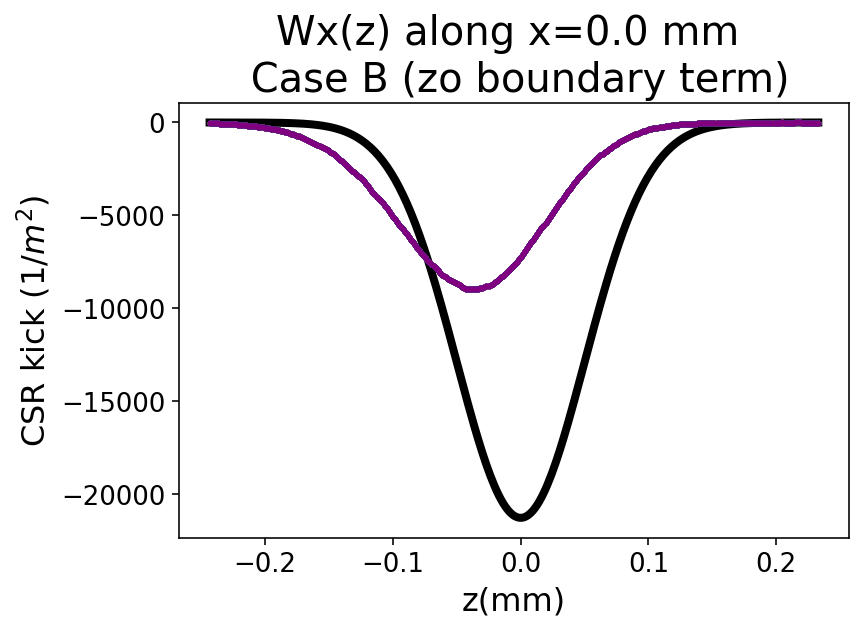

In [179]:
# Check the three contribution terms of Wx(z)
# ix_term is...
# 3 : Wx integral term
ix_term = 5
wx1 = wake_list[0][ix_term] 
wx2 = wake_list[1][ix_term] 
wx3 = wake_list[2][ix_term] 
wx4 = wake_list[3][ix_term] 
wx5 = wake_list[4][ix_term] 
wx6 = wake_list[5][ix_term] 

plt.scatter(zvec*10**3, wx1, color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3, wx2, color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3, wx3, color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3, wx4, color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3, wx5, color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3, wx6, color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )

plot_Wx_caseB_theory(phi_vec[0], 'black', 'Simplified theory')


plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
#plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B (zi boundary term)',  fontsize=20)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case B (zo boundary term)',  fontsize=20)
#plt.legend()